### Experiment with Hao's Model

In [1]:
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential, layers
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn
from imblearn.under_sampling import RandomUnderSampler
from keras.regularizers import l2
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
from scipy import special
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow_privacy.privacy.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackType
import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack
from scipy import special


/ssd003/projects/aieng/public/pets_unified/lib/python3.8/site-packages/tensorflow_privacy/privacy/membership_inference_attack/__init__.py:18: UserWarning: 
Membership inference attack sources were moved. Please replace
import tensorflow_privacy.privacy.membership_inference_attack

with
import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack
  warnings.warn(


In [2]:
df = pd.read_csv("/ssd003/projects/pets/datasets/homecredit_train.csv")

<AxesSubplot:>

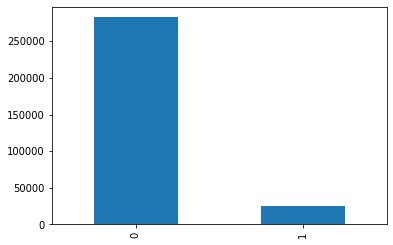

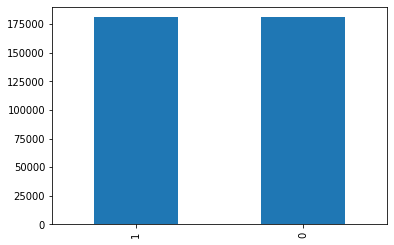

In [3]:
fig, ax = plt.subplots()
df['target'].value_counts().plot(ax=ax, kind='bar')

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Oversampling target labels
max_size = train_df['target'].value_counts().max()

# lst = [train_df]
# for class_index, group in train_df.groupby('target'):
#     lst.append(group.sample(max_size-len(group), replace=True))
# X_train = pd.concat(lst)

X_train = train_df.drop(['target'], axis=1)
y_train = train_df['target']

rus = SMOTE(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

X_test = test_df.drop(['target'], axis=1)
y_test = test_df['target']

X_val = val_df.drop(['target'], axis=1)
y_val = val_df['target']

fig, ax = plt.subplots()
y_train.value_counts().plot(ax=ax, kind='bar')

# y_train = np.array(y_train, dtype=np.float32) 
# y_test = np.array(y_test, dtype=np.float32) 
# y_val = np.array(y_val, dtype=np.float32)

# y_train = y_train.flatten()
# y_test = y_test.flatten()
# y_val = y_val.flatten()



In [4]:
scaler = StandardScaler()
X_train_transform = scaler.fit_transform(X_train)
X_val_transform = scaler.transform(X_val)
X_test_transform = scaler.transform(X_test)

X_train_transform = pd.DataFrame(X_train_transform,columns = X_train.columns)
X_val_transform = pd.DataFrame(X_val_transform,columns = X_train.columns)
X_test_transform = pd.DataFrame(X_test_transform, columns = X_train.columns)

X_train_transform = np.clip(X_train_transform, -5, 5)
X_val_transform = np.clip(X_val_transform, -5, 5)
X_test_transform = np.clip(X_test_transform, -5, 5)

### Defining Model

In [5]:
def make_model(logits, last_nodes):
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(X_train.shape[-1],)))
    model.add(Dropout(0.5))
    if not logits:
        model.add(Dense(last_nodes, activation='sigmoid'))
    else:
        model.add(Dense(last_nodes))    
    return model

def compiled_model(model, learning_rate=0.01, noise_multiplier=0.9, l2_norm_clip=0.9, dp=False):
    if dp:
        optimizer = DPKerasSGDOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,
            num_microbatches=1,
            learning_rate=learning_rate)
        model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), \
                     optimizer=optimizer, metrics= [tf.keras.metrics.AUC(from_logits=True)])
    else:
        model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), \
                      optimizer='adam', metrics=[tf.keras.metrics.AUC(from_logits=True)])
    
    return model

In [6]:
low_privacy_param = {'learning_rate' : 0.0005,
                     'noise_multiplier' :1,
                     'L2_clip' :0.9,
                     'batch_size' :1024}

high_privacy_param = {'learning_rate':0.0005,
                     'noise_multiplier':3,
                     'L2_clip':1,
                     'batch_size':1024}

### Experiment is to train with High_privacy and conduct an MIA and Low_privacy and conduct MIA

In [7]:
high_priv_model = compiled_model(model=make_model(logits=True, last_nodes=1), dp=True, \
                                learning_rate=high_privacy_param['learning_rate'], \
                                noise_multiplier=high_privacy_param['noise_multiplier'], \
                                l2_norm_clip=high_privacy_param['L2_clip'] \
                                )
low_priv_model = compiled_model(model=make_model(logits=True, last_nodes=1), dp=True, \
                                learning_rate=low_privacy_param['learning_rate'], \
                                noise_multiplier=low_privacy_param['noise_multiplier'], \
                                l2_norm_clip=low_privacy_param['L2_clip'] \
                                )

base_line_model = compiled_model(model=make_model(logits=True, last_nodes=1))

In [8]:
hist1 = high_priv_model.fit(X_train_transform, y_train, epochs=1000, batch_size=2048, \
                            validation_data=(X_val_transform, y_val))
hist2 = low_priv_model.fit(X_train_transform, y_train,  epochs=1000, batch_size=2048, \
                           validation_data=(X_val_transform, y_val))
hist3 = base_line_model.fit(X_train_transform, y_train, epochs=1000, batch_size=2048, \
                            validation_data=(X_val_transform, y_val))

Epoch 1/1000
177/177 [==============================] - 5s 9ms/step - loss: 0.8635 - auc: 0.4837 - val_loss: 0.9987 - val_auc: 0.5020
Epoch 2/1000
177/177 [==============================] - 1s 6ms/step - loss: 0.8544 - auc: 0.4896 - val_loss: 0.9628 - val_auc: 0.5143
Epoch 3/1000
177/177 [==============================] - 1s 6ms/step - loss: 0.8463 - auc: 0.4955 - val_loss: 0.9408 - val_auc: 0.5145
Epoch 4/1000
177/177 [==============================] - 1s 6ms/step - loss: 0.8434 - auc: 0.4959 - val_loss: 0.9091 - val_auc: 0.5242
Epoch 5/1000
177/177 [==============================] - 1s 6ms/step - loss: 0.8318 - auc: 0.5010 - val_loss: 0.8688 - val_auc: 0.5325
Epoch 6/1000
177/177 [==============================] - 1s 6ms/step - loss: 0.8137 - auc: 0.5074 - val_loss: 0.8035 - val_auc: 0.5378
Epoch 7/1000
177/177 [==============================] - 1s 6ms/step - loss: 0.8166 - auc: 0.5114 - val_loss: 0.8374 - val_auc: 0.5404
Epoch 8/1000
177/177 [==============================] - 1s 6ms

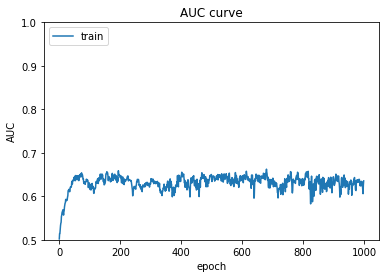

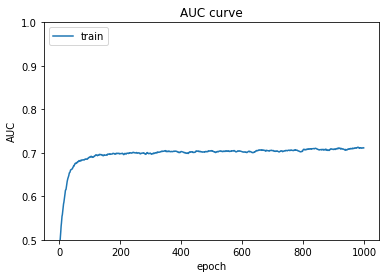

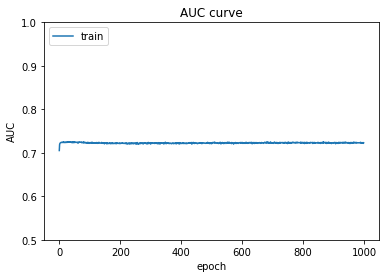

In [10]:
def plot_auc(history, key):
    plt.plot(history.history[key])
    plt.title('AUC curve')
    plt.ylabel('AUC')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylim(0.5, 1)
    plt.show()

plot_auc(hist1, 'val_auc')
plot_auc(hist2, 'val_auc_1')
plot_auc(hist3, 'val_auc_2')

In [17]:
def membership_inference_attack_binary(model, X_train, X_test, train_label, test_label):
    print('Predict on train...')
    logits_train = model.predict(X_train)

    print('Predict on test...')
    logits_test = model.predict(X_test)

    print('Apply softmax to get probabilities from logits...')
    prob_train = special.expit(logits_train)
    prob_test = special.expit(logits_test)
    y_train_pred = np.argmax(prob_train)
    y_test_pred = np.argmax(prob_test)
    
    print('Compute losses...')
    bce = tf.keras.backend.binary_crossentropy
    constant = tf.keras.backend.constant

    y_train = np.array(train_label, dtype=np.float32) 
    y_test =  np.array(test_label, dtype=np.float32) 

    y_train = y_train.flatten()
    y_test = y_test.flatten()
    
    loss_train = bce(constant(y_train), constant(y_train_pred), from_logits=False).numpy()
    loss_test = bce(constant(y_test), constant(y_test_pred), from_logits=False).numpy()
    
    attack_types = [
    AttackType.THRESHOLD_ATTACK,
    AttackType.LOGISTIC_REGRESSION,
    ]
    
    attack_input = AttackInputData(
      logits_train = logits_train,
      logits_test = logits_test,
      loss_train = loss_train,
      loss_test = loss_test,
      labels_train = y_train.astype(np.int8),
      labels_test = y_test.astype(np.int8)
    )
    slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = True,
    by_percentiles = False,
    by_classification_correctness = True)
    
    attacks_result = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_types)
    
    print(attacks_result.summary(by_slices=True))
        
    return plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve)

Predict on train...
Predict on test...
Apply softmax to get probabilities from logits...
Compute losses...
Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an AUC of 0.71 on slice Entire dataset
  THRESHOLD_ATTACK (with 361944 training and 61503 test examples) achieved an advantage of 0.42 on slice Entire dataset

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an AUC of 0.71
  THRESHOLD_ATTACK (with 361944 training and 61503 test examples) achieved an advantage of 0.42

Best-performing attacks over slice: "CLASS=0"
  THRESHOLD_ATTACK (with 180972 training and 56554 test examples) achieved an AUC of 0.50
  LOGISTIC_REGRESSION (with 56554 training and 56554 test examples) achieved an advantage of 0.01

Best-performing attacks over slice: "CLASS=1"
  LOGISTIC_REGRESSION (with 4949 training and 4949 test examples) achieved an AUC of 0.52
  L

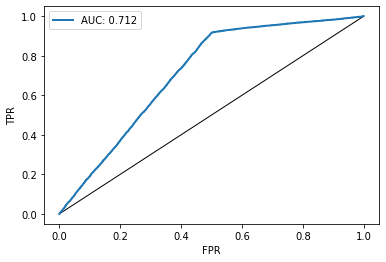

In [18]:
plot1 = membership_inference_attack_binary(high_priv_model, X_train_transform, X_test_transform, y_train, y_test)


Predict on train...
Predict on test...
Apply softmax to get probabilities from logits...
Compute losses...
Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an AUC of 0.71 on slice Entire dataset
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an advantage of 0.42 on slice Entire dataset

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an AUC of 0.71
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an advantage of 0.42

Best-performing attacks over slice: "CLASS=0"
  LOGISTIC_REGRESSION (with 56554 training and 56554 test examples) achieved an AUC of 0.50
  LOGISTIC_REGRESSION (with 56554 training and 56554 test examples) achieved an advantage of 0.01

Best-performing attacks over slice: "CLASS=1"
  LOGISTIC_REGRESSION (with 4949 training and 4949 test examples) achieved an AUC of 0.

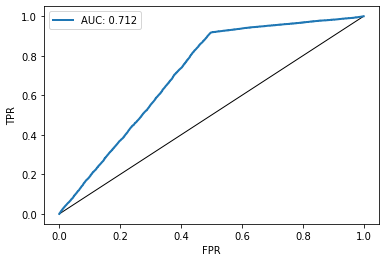

In [19]:
plot2= membership_inference_attack_binary(low_priv_model, X_train_transform, X_test_transform, y_train, y_test)


Predict on train...
Predict on test...
Apply softmax to get probabilities from logits...
Compute losses...
Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an AUC of 0.71 on slice Entire dataset
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an advantage of 0.43 on slice Entire dataset

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an AUC of 0.71
  LOGISTIC_REGRESSION (with 61503 training and 61503 test examples) achieved an advantage of 0.43

Best-performing attacks over slice: "CLASS=0"
  LOGISTIC_REGRESSION (with 56554 training and 56554 test examples) achieved an AUC of 0.51
  LOGISTIC_REGRESSION (with 56554 training and 56554 test examples) achieved an advantage of 0.01

Best-performing attacks over slice: "CLASS=1"
  LOGISTIC_REGRESSION (with 4949 training and 4949 test examples) achieved an AUC of 0.

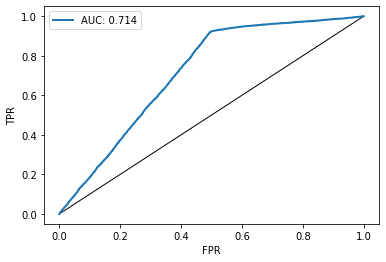

In [20]:
plot3=membership_inference_attack_binary(base_line_model, X_train_transform, X_test_transform, y_train, y_test)
